In [50]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input

import numpy as np
import json

from tensorflow.keras import metrics, optimizers

from tensorflow.keras.callbacks import ModelCheckpoint

import itertools
import matplotlib.pyplot as plt

import os
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    figname = title + '.png'
    
    plt.savefig(figname, dpi = 600)

In [54]:
def top_5_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)



def get_top_k_predictions(preds, label_map, k=5, print_flag=False):
    sorted_array = np.argsort(preds)[::-1]
    top_k = sorted_array[:k]
    label_map_flip = dict((v,k) for k,v in label_map.items())
    
    y_pred = []
    for label_index in top_k:
        if print_flag:
            print("{} ({})".format(label_map_flip[label_index], preds[label_index]))
        y_pred.append(label_map_flip[label_index])
        
    return y_pred

In [55]:
def save2saved2tflite(model, output_model_path):
    saved_model_dir = '' #means current directory
    tf.saved_model.save(model, saved_model_dir) #saves to the current directory
    converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
    tflite_model = converter.convert() #converts our model into a .tflite model which flutter uses for ondevice machine learning
    with open(output_model_path, 'wb') as f: #to write the converted model into a file, written as binary so add 'wb' instead of 'w'
       f.write(tflite_model)

def save4mkeras2tflite(model, output_model_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    quantized_tflite_model = converter.convert()
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    baseline_tflite_model = converter.convert()

In [58]:
# steps_per_epoch = len(X_train)//batch_size
# validation_steps = len(X_test)//batch_size # if you have validation data 
batch_size = 20 #40
epochs = 20 #25   # 200

# dimensions of our images.
img_width, img_height = 224, 224

input_tensor = Input(shape=(224,224,3))

nb_training_samples =  132  # 1600 cough/dog 85+85 + clap 44.
nb_validation_samples =  24 # 400 # Set parameter values 3(labels)*8(testing samples per label)

n_targets = 3

In [59]:
training_data_dir = 'wavelets/wavelet_training'

training_datagen = image.ImageDataGenerator(
    rescale=1./255)

training_generator = training_datagen.flow_from_directory(
    training_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

# validation generator configuration
validation_data_dir = 'wavelets/wavelet_selected/testing/'

validation_datagen = image.ImageDataGenerator(
    rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 132 images belonging to 3 classes.
Found 24 images belonging to 3 classes.


In [61]:
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
print('Model loaded.')
base_model.summary()


Model loaded.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128

In [62]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(n_targets, activation='softmax'))

top_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 771       
Total params: 6,423,555
Trainable params: 6,423,555
Non-trainable params: 0
_________________________________________________________________


In [63]:
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [64]:
num_layers_to_freeze = 15


In [65]:
for layer in model.layers[:num_layers_to_freeze]:
    layer.trainable = False


model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy', top_5_accuracy])


# serialize model to JSON
model_json = model.to_json()
model_filename = "cough_model_artifacts/vgg16_model_{}_frozen_layers.json".format(num_layers_to_freeze)

with open(model_filename, "w") as json_file:
    json_file.write(model_json)
    

In [66]:
filepath = "cough_model_artifacts/esc50_vgg16_stft_weights_train_last_2_base_layers_best.hdf5"
metric = 'val_accuracy'

best_model_checkpoint = ModelCheckpoint(filepath, monitor=metric, verbose=5, save_best_only=True, mode='max')
callbacks_list = [best_model_checkpoint]


model.fit_generator(
    training_generator,
    steps_per_epoch=nb_training_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples/batch_size,
    callbacks=callbacks_list)


Epoch 1/20
6/6 [==============================] - 66s 10s/step - loss: 1.3418 - accuracy: 0.2803 - top_5_accuracy: 1.0000 - val_loss: 1.0867 - val_accuracy: 0.3750 - val_top_5_accuracy: 1.0000

Epoch 00001: val_accuracy improved from -inf to 0.37500, saving model to cough_model_artifacts/esc50_vgg16_stft_weights_train_last_2_base_layers_best.hdf5
Epoch 2/20
6/6 [==============================] - 69s 11s/step - loss: 1.2324 - accuracy: 0.3864 - top_5_accuracy: 1.0000 - val_loss: 1.0433 - val_accuracy: 0.5417 - val_top_5_accuracy: 1.0000

Epoch 00002: val_accuracy improved from 0.37500 to 0.54167, saving model to cough_model_artifacts/esc50_vgg16_stft_weights_train_last_2_base_layers_best.hdf5
Epoch 3/20
6/6 [==============================] - 64s 10s/step - loss: 1.1158 - accuracy: 0.3561 - top_5_accuracy: 1.0000 - val_loss: 0.9865 - val_accuracy: 0.4583 - val_top_5_accuracy: 1.0000

Epoch 00003: val_accuracy did not improve from 0.54167
Epoch 4/20
6/6 [==============================] - 

In [67]:
label_map = (training_generator.class_indices)

In [68]:
json = json.dumps(label_map)
f = open("cough_model_artifacts/cough_label_map.json","w")
f.write(json)
f.close()

In [69]:
model.save("cough_model_artifacts/cough_model", save_format="tf")


INFO:tensorflow:Assets written to: cough_model_artifacts/cough_model/assets


In [70]:
testing_dir = './wavelets/wavelet_selected/testing/'

y_true = []
y_pred = []


for label in label_map.keys():
    
    file_list = os.listdir(testing_dir + label)
    
    for file_name in file_list:
        img_path = testing_dir + label + '/' + file_name
        
        img = image.load_img(img_path, target_size=(224, 224))
        
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)* 1./255
        
        preds = model.predict(x)[0]
        
        y_true.append(label)
        y_pred.append(get_top_k_predictions(preds, label_map, k=1)[0])


Confusion matrix, without normalization
Normalized confusion matrix


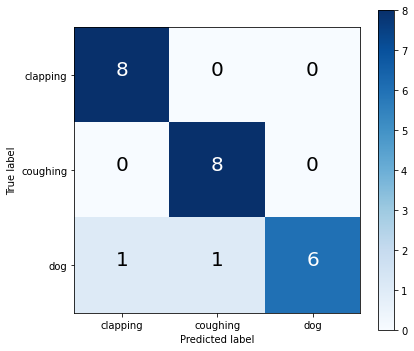

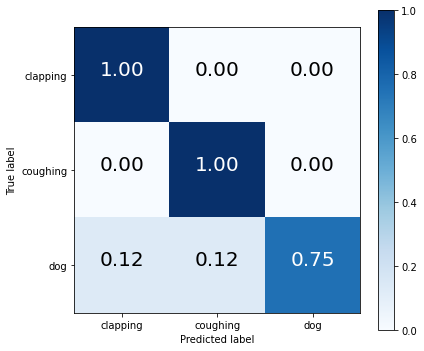

In [71]:
cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm, sorted(label_map.keys()), normalize=False, title = 'cough_model_artifacts/wavelet_cough_vgg16')

plot_confusion_matrix(cm, sorted(label_map.keys()), normalize=True, title = 'cough_model_artifacts/wavelet_cough_normalized')


In [72]:
print(classification_report(y_true, y_pred, target_names = sorted(label_map.keys()) ))


print('xxxxxxx Done Testing xxxxxxxx')

              precision    recall  f1-score   support

    clapping       0.89      1.00      0.94         8
    coughing       0.89      1.00      0.94         8
         dog       1.00      0.75      0.86         8

    accuracy                           0.92        24
   macro avg       0.93      0.92      0.91        24
weighted avg       0.93      0.92      0.91        24

xxxxxxx Done Testing xxxxxxxx


file: rob_1.2.1.png
pedicted classes: 
[0.07509854 0.70664585 0.21825561]
{'clapping': 0, 'coughing': 1, 'dog': 2}
file: rob_1.2.3.png
pedicted classes: 
[0.12526356 0.6229432  0.25179315]
{'clapping': 0, 'coughing': 1, 'dog': 2}
file: rob_1.2.2.png
pedicted classes: 
[0.09444003 0.7520449  0.15351509]
{'clapping': 0, 'coughing': 1, 'dog': 2}
file: rob_1.1.1.png
pedicted classes: 
[0.07313098 0.761097   0.16577205]
{'clapping': 0, 'coughing': 1, 'dog': 2}
file: rob_1.3.3.png
pedicted classes: 
[0.10178683 0.6423016  0.25591153]
{'clapping': 0, 'coughing': 1, 'dog': 2}
file: rob_1.3.2.png
pedicted classes: 
[0.10570247 0.6862415  0.20805597]
{'clapping': 0, 'coughing': 1, 'dog': 2}
file: rob_1.1.2.png
pedicted classes: 
[0.09765886 0.69012654 0.21221465]
{'clapping': 0, 'coughing': 1, 'dog': 2}
file: rob_1.3.1.png
pedicted classes: 
[0.08588168 0.7040726  0.21004575]
{'clapping': 0, 'coughing': 1, 'dog': 2}
file: rob_1.1.3.png
pedicted classes: 
[0.14562687 0.46445858 0.38991448]
{'clap

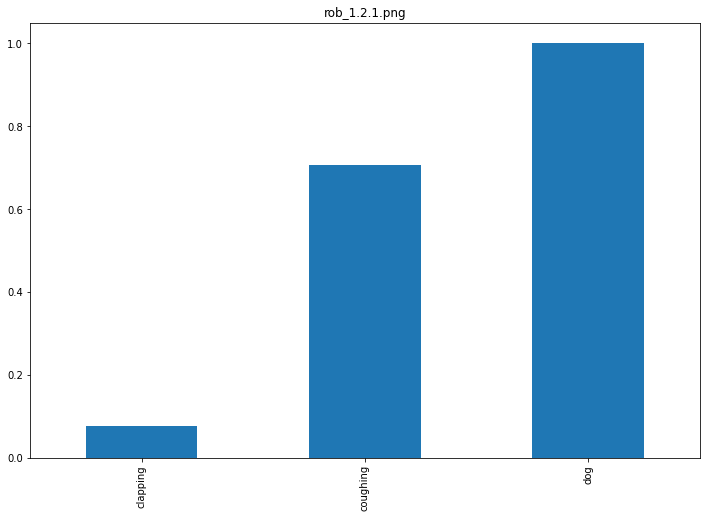

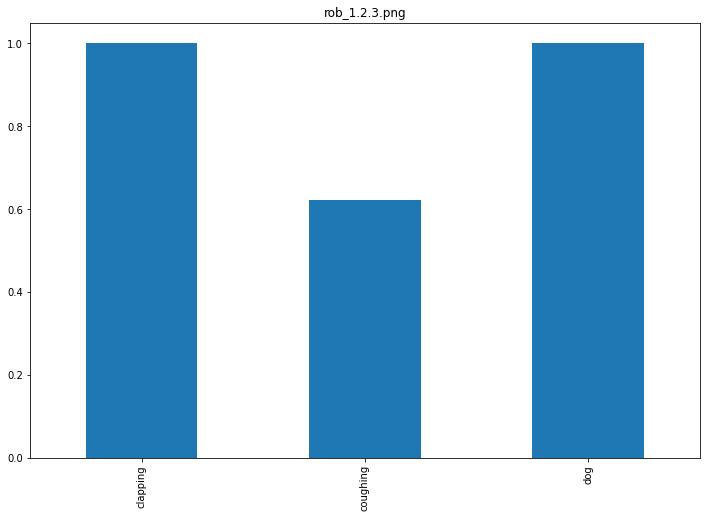

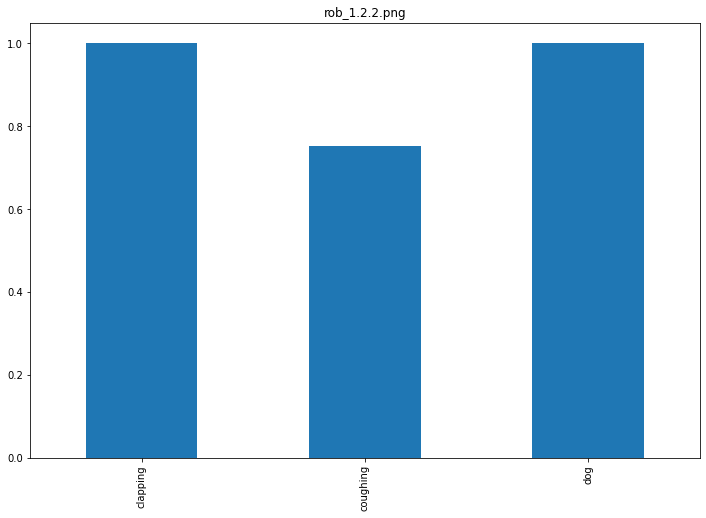

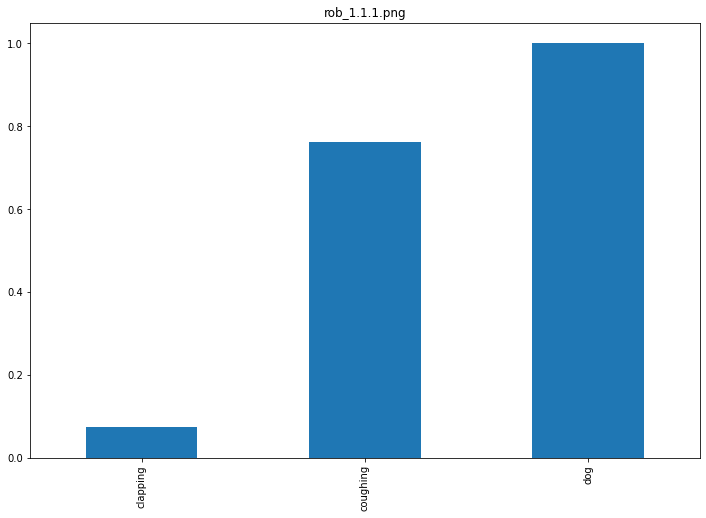

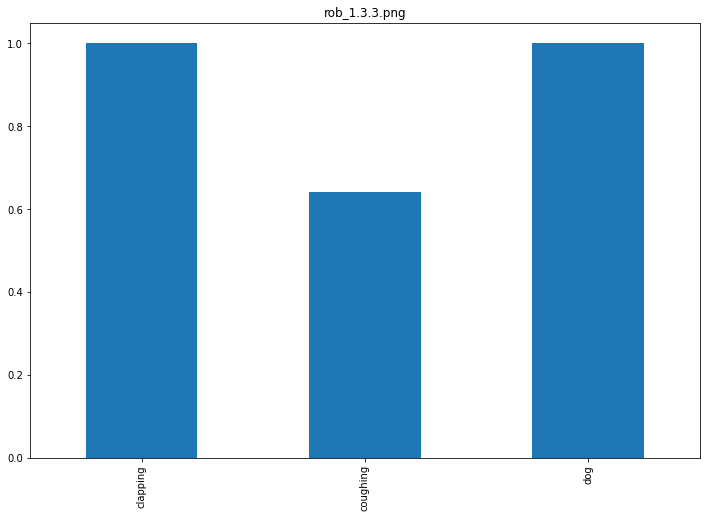

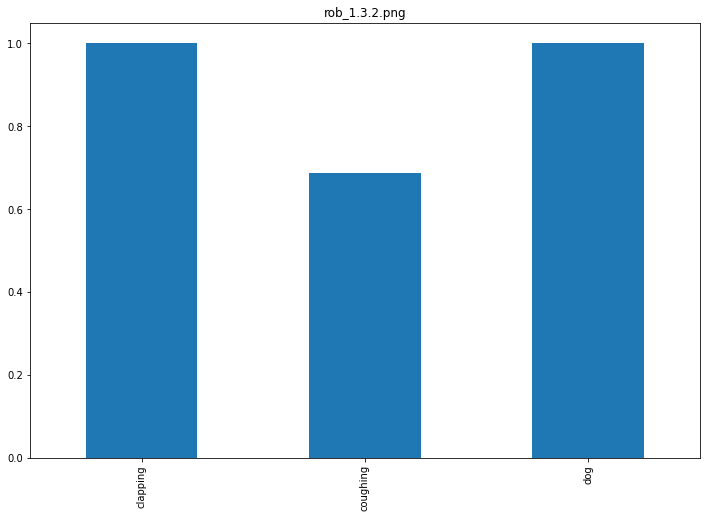

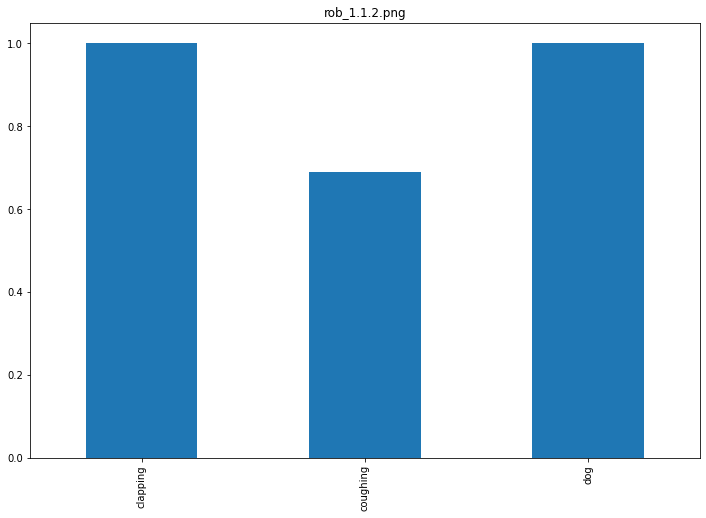

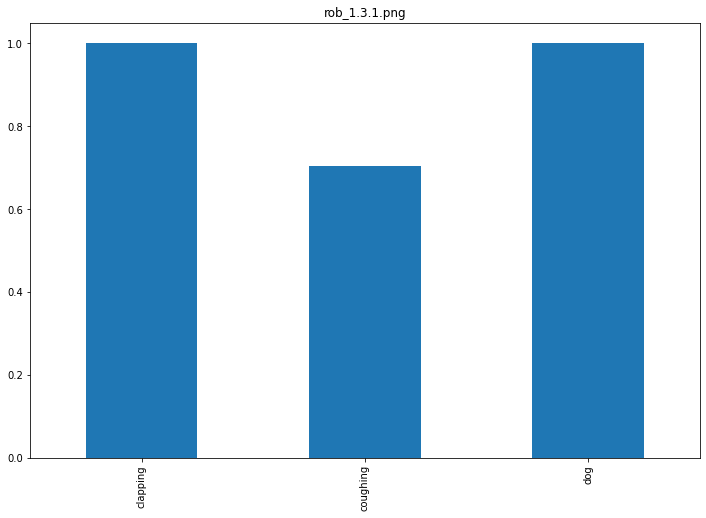

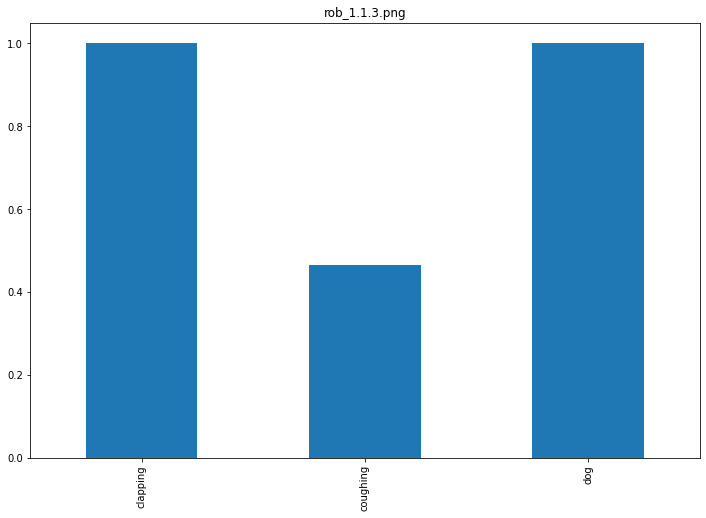

In [75]:
testing_dir = './wavelets/wavelet_live/'
    
file_list = os.listdir(testing_dir)

for file_name in file_list:
    if(file_name.endswith('.png')):
        y_true = []
        y_pred = []
        img_path = testing_dir + '/' + file_name

        img = image.load_img(img_path, target_size=(224, 224))
        
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)* 1./255
        
        preds = model.predict(x)[0]
        print("file: " + file_name)
        print("pedicted classes: ")
        print(preds)
        if(round(preds[0], 2) > 0.08):
            preds[0] = 1
        if(round(preds[1], 2) > 0.83):
            preds[1] = 1
        if(round(preds[2], 2) > 0.04):
            preds[2] = 1
        # if(preds[1] < 0.75):
        #     preds[1] = 0
        print(label_map)

        # Plot the figure.
        freq_series = pd.Series(preds)

        plt.figure(figsize=(12, 8))
        ax = freq_series.plot(kind="bar")
        ax.set_title(file_name)
        ax.set_xticklabels(label_map)

        rects = ax.patches

        for rect, label in zip(rects, label_map):
            height = rect.get_height()

        plt.savefig(img_path+"_plotted.png")


In [22]:
print('xxxxxxx Done xxxxxxxx')

xxxxxxx Done xxxxxxxx
